In [ ]:
!apt install swig
!pip install stable-baselines3[extra]

import multiprocessing
import multiprocessing.connection

import math
import numpy as np
import torch
from torch import optim
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import gym

!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid
import gradcam
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

import base64
from pathlib import Path

from IPython import display as ipythondisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,468 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpackin

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/cmd_util.py:6: FutureWarning: Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.
  "Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.", FutureWarning


Importing preprocessing code

In [ ]:
import collections
from collections import deque
import cv2
import gym
from gym import Wrapper
import gym.spaces
from gym.spaces import Box
import numpy as np


def make_env_with_wrappers(env_name, seed):
    env = gym.make(env_name)
    env.seed(seed)
    env = AtariPreprocessing(env)
    env = FrameStack(env, 4)
    return env


def make_env_function(env_name, seed):
    def _thunk():
        env = make_env_with_wrappers(env_name, seed)
        return env

    return _thunk


class AtariPreprocessing(gym.Wrapper):
    r"""Atari 2600 preprocessings. 
    This class follows the guidelines in 
    Machado et al. (2018), "Revisiting the Arcade Learning Environment: 
    Evaluation Protocols and Open Problems for General Agents".
    Specifically:
    * NoopReset: obtain initial state by taking random number of no-ops on reset. 
    * Frame skipping: 4 by default
    * Max-pooling: most recent two observations
    * Termination signal when a life is lost: turned off by default. Not recommended by Machado et al. (2018).
    * Resize to a square image: 84x84 by default
    * Grayscale observation: optional
    * Scale observation: optional
    Args:
        env (Env): environment
        noop_max (int): max number of no-ops
        frame_skip (int): the frequency at which the agent experiences the game. 
        screen_size (int): resize Atari frame
        terminal_on_life_loss (bool): if True, then step() returns done=True whenever a
            life is lost. 
        grayscale_obs (bool): if True, then gray scale observation is returned, otherwise, RGB observation
            is returned.
        grayscale_newaxis (bool): if True and grayscale_obs=True, then a channel axis is added to
            grayscale observations to make them 3-dimensional.
        scale_obs (bool): if True, then observation normalized in range [0,1] is returned. It also limits memory
            optimization benefits of FrameStack Wrapper.
    """

    def __init__(self, env, noop_max=30, frame_skip=4, screen_size=84, terminal_on_life_loss=True, grayscale_obs=True,
                 grayscale_newaxis=False, scale_obs=False):
        super().__init__(env)
        assert cv2 is not None, \
            "opencv-python package not installed! Try running pip install gym[atari] to get dependencies  for atari"
        assert frame_skip > 0
        assert screen_size > 0
        assert noop_max >= 0
        if frame_skip > 1:
            assert 'NoFrameskip' in env.spec.id, 'disable frame-skipping in the original env. for more than one' \
                                                 ' frame-skip as it will be done by the wrapper'
        self.noop_max = noop_max
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

        self.frame_skip = frame_skip
        self.screen_size = screen_size
        self.terminal_on_life_loss = terminal_on_life_loss
        self.grayscale_obs = grayscale_obs
        self.grayscale_newaxis = grayscale_newaxis
        self.scale_obs = scale_obs

        # buffer of most recent two observations for max pooling
        if grayscale_obs:
            self.obs_buffer = [np.empty(env.observation_space.shape[:2], dtype=np.uint8),
                               np.empty(env.observation_space.shape[:2], dtype=np.uint8)]
        else:
            self.obs_buffer = [np.empty(env.observation_space.shape, dtype=np.uint8),
                               np.empty(env.observation_space.shape, dtype=np.uint8)]

        self.ale = env.unwrapped.ale
        self.lives = 0
        self.game_over = False

        _low, _high, _obs_dtype = (0, 255, np.uint8) if not scale_obs else (0, 1, np.float32)
        _shape = (screen_size, screen_size, 1 if grayscale_obs else 3)
        if grayscale_obs and not grayscale_newaxis:
            _shape = _shape[:-1]  # Remove channel axis
        self.observation_space = Box(low=_low, high=_high, shape=_shape, dtype=_obs_dtype)

    def step(self, action):
        R = 0.0

        for t in range(self.frame_skip):
            _, reward, done, info = self.env.step(action)
            R += reward
            self.game_over = done

            if self.terminal_on_life_loss:
                new_lives = self.ale.lives()
                done = done or new_lives < self.lives
                self.lives = new_lives

            if done:
                break
            if t == self.frame_skip - 2:
                if self.grayscale_obs:
                    self.ale.getScreenGrayscale(self.obs_buffer[1])
                else:
                    self.ale.getScreenRGB2(self.obs_buffer[1])
            elif t == self.frame_skip - 1:
                if self.grayscale_obs:
                    self.ale.getScreenGrayscale(self.obs_buffer[0])
                else:
                    self.ale.getScreenRGB2(self.obs_buffer[0])
        return self._get_obs(), R, done, info

    def reset(self, **kwargs):
        # NoopReset
        self.env.reset(**kwargs)
        noops = self.env.unwrapped.np_random.randint(1, self.noop_max + 1) if self.noop_max > 0 else 0
        for _ in range(noops):
            _, _, done, _ = self.env.step(0)
            if done:
                self.env.reset(**kwargs)

        self.lives = self.ale.lives()
        if self.grayscale_obs:
            self.ale.getScreenGrayscale(self.obs_buffer[0])
        else:
            self.ale.getScreenRGB2(self.obs_buffer[0])
        self.obs_buffer[1].fill(0)
        return self._get_obs()

    def _get_obs(self):
        if self.frame_skip > 1:  # more efficient in-place pooling
            np.maximum(self.obs_buffer[0], self.obs_buffer[1], out=self.obs_buffer[0])
        obs = cv2.resize(self.obs_buffer[0], (self.screen_size, self.screen_size), interpolation=cv2.INTER_AREA)

        if self.scale_obs:
            obs = np.asarray(obs, dtype=np.float32) / 255.0
        else:
            obs = np.asarray(obs, dtype=np.uint8)

        if self.grayscale_obs and self.grayscale_newaxis:
            obs = np.expand_dims(obs, axis=-1)  # Add a channel axis
        return obs

class LazyFrames(object):
    r"""Ensures common frames are only stored once to optimize memory use.
    To further reduce the memory use, it is optionally to turn on lz4 to
    compress the observations.
    .. note::
        This object should only be converted to numpy array just before forward pass.
    Args:
        lz4_compress (bool): use lz4 to compress the frames internally
    """
    __slots__ = ('frame_shape', 'dtype', 'shape', 'lz4_compress', '_frames')

    def __init__(self, frames, lz4_compress=False):
        self.frame_shape = tuple(frames[0].shape)
        self.shape = (len(frames),) + self.frame_shape
        self.dtype = frames[0].dtype
        if lz4_compress:
            from lz4.block import compress
            frames = [compress(frame) for frame in frames]
        self._frames = frames
        self.lz4_compress = lz4_compress

    def __array__(self, dtype=None):
        arr = self[:]
        if dtype is not None:
            return arr.astype(dtype)
        return arr

    def __len__(self):
        return self.shape[0]

    def __getitem__(self, int_or_slice):
        if isinstance(int_or_slice, int):
            return self._check_decompress(self._frames[int_or_slice])  # single frame
        return np.stack([self._check_decompress(f) for f in self._frames[int_or_slice]], axis=0)

    def __eq__(self, other):
        return self.__array__() == other

    def _check_decompress(self, frame):
        if self.lz4_compress:
            from lz4.block import decompress
            return np.frombuffer(decompress(frame), dtype=self.dtype).reshape(self.frame_shape)
        return frame


class FrameStack(Wrapper):
    r"""Observation wrapper that stacks the observations in a rolling manner.
    For example, if the number of stacks is 4, then the returned observation contains
    the most recent 4 observations. For environment 'Pendulum-v0', the original observation
    is an array with shape [3], so if we stack 4 observations, the processed observation
    has shape [4, 3].
    .. note::
        To be memory efficient, the stacked observations are wrapped by :class:`LazyFrame`.
    .. note::
        The observation space must be `Box` type. If one uses `Dict`
        as observation space, it should apply `FlattenDictWrapper` at first.
    Example::
        >>> import gym
        >>> env = gym.make('PongNoFrameskip-v0')
        >>> env = FrameStack(env, 4)
        >>> env.observation_space
        Box(4, 210, 160, 3)
    Args:
        env (Env): environment object
        num_stack (int): number of stacks
        lz4_compress (bool): use lz4 to compress the frames internally
    """
    def __init__(self, env, num_stack, lz4_compress=False):
        super(FrameStack, self).__init__(env)
        self.num_stack = num_stack
        self.lz4_compress = lz4_compress

        self.frames = deque(maxlen=num_stack)

        low = np.repeat(self.observation_space.low[np.newaxis, ...], num_stack, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], num_stack, axis=0)
        self.observation_space = Box(low=low, high=high, dtype=self.observation_space.dtype)

    def _get_observation(self):
        assert len(self.frames) == self.num_stack, (len(self.frames), self.num_stack)
        return LazyFrames(list(self.frames), self.lz4_compress)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.frames.append(observation)
        return self._get_observation(), reward, done, info

    def reset(self, **kwargs):
        observation = self.env.reset(**kwargs)
        [self.frames.append(observation) for _ in range(self.num_stack)]
        return self._get_observation()

In [ ]:
# make env and set to a random state
env = make_env_with_wrappers('PongNoFrameskip-v4', 0)
state = env.reset()
for n in range(400):
  state, _ , _ , _ = env.step(0)
input = torch.FloatTensor(state).unsqueeze(0)

# load function for models (CPU only)
def load(model, path):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(path)
    # replace model weights with loaded weights 
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict }
    model_dict.update(pretrained_dict)
    model.load_state_dict(pretrained_dict)
    return model


Import Actor Critic model. Attn_type refers to the attention to be used specified by Attn RvuAttn CrossAttn or NoAttn

In [ ]:

class ActorCriticNet(nn.Module):
    def __init__(self, shape, ac_s, attn_type: str = 'Attn',adaptive: bool = False):
        super().__init__()
        if attn_type == 'Attn':
            self.layer = MultiHeadAttn(size=32, adaptive=adaptive)
        elif attn_type == 'RvuAttn':
            self.layer = RvuAttn(size=32, adaptive=adaptive)
        elif attn_type == 'CrossAttn':
            self.layer = CrossAttn(size=32, adaptive=adaptive)
        elif attn_type == 'xAttn':
            self.layer = xAttn(size=32, adaptive=adaptive)
        else:
            self.layer = torch.nn.Dropout(0)
        self.c1 = nn.Conv2d(shape[0], 32, 8, stride=4)
        self.c2 = nn.Conv2d(32, 64, 4, stride=2)
        self.c3 = nn.Conv2d(64, 64, 3, stride=1)
        self.conv_out = self._get_conv_out(shape)

        self.l1 = nn.Linear(self.conv_out, 512)
        self.critic = nn.Linear(512, 1)
        self.actor = nn.Linear(512, ac_s)

    def cnn_layer(self, x):
        h = F.relu(self.c1(x))
        h = self.layer(h)
        h = F.relu(self.c2(h))
        h = F.relu(self.c3(h))
        return h

    def shared_layer(self, x):
        h = self.cnn_layer(x)
        h = h.reshape(-1).view(-1, self.conv_out)
        h = F.relu(self.l1(h))
        return h

    def forward(self, x):
        h = self.shared_layer(x)
        actor_logits = self.actor(h)
        values = self.critic(h)
        prob = F.softmax(actor_logits, dim=-1)
        acts = prob.multinomial(1)
        return actor_logits

    def _get_conv_out(self, shape):
        x = torch.zeros(1, *shape)
        h = self.cnn_layer(x)
        return int(np.prod(h.size()))

class MultiHeadAttn(nn.Module):
    def __init__(self, size, adaptive):
        super().__init__()
        #Approximator function for weight q,k,v
        self.w_q = nn.Conv2d(in_channels=size ,out_channels=size , kernel_size=1)
        self.w_k = nn.Conv2d(in_channels=size ,out_channels=size , kernel_size=1)
        self.w_v = nn.Conv2d(in_channels=size ,out_channels=size , kernel_size=1)
        #self.out = nn.Conv2d(in_channels=size ,out_channels=size , kernel_size=1)
        self.adaptive = adaptive
        if adaptive:
            self.W = torch.nn.Parameter(torch.randn(1))
            self.W.requires_grad = True

    def forward(self, a, dropout=None):
        q = self.w_q(a)
        k = self.w_k(a)
        v = self.w_v(a)

        attention = self.dot_pdt_attention(q, k, v, dropout)
        #out = F.relu(self.out(attention))
        if self.adaptive:
            attention*=self.W
        out = a + attention
        return out

      #scaled dot pdt attention
    def dot_pdt_attention(self, q, k, v, dropout):
        #get n dimension size from [32,32,20,20]
        n = q.size(-1)
        k_t = k.transpose(-2,-1)

        scores = torch.matmul(q, k_t)/np.sqrt(n)
        p_attn = F.softmax(scores,dim=-1)
        if dropout is not None:
          p_attn = dropout(p_attn)
        return torch.matmul(p_attn, v)


class RvuAttn(nn.Module):
    def __init__(self, size, adaptive):
        super().__init__()
        #Approximator function for weight q,k,v
        self.w_q = nn.Conv2d(in_channels=size ,out_channels=size , kernel_size=1)
        self.w_k = nn.Conv2d(in_channels=size ,out_channels=size , kernel_size=1)
        self.w_v = nn.Conv2d(in_channels=size ,out_channels=size , kernel_size=1)
        self.adaptive = adaptive
        if adaptive:
            self.W = torch.nn.Parameter(torch.randn(1))
            self.W.requires_grad = True
    def forward(self, a, dropout=None):
        q = self.w_q(a).permute(0, 2, 3, 1)
        k = self.w_k(a).permute(0, 2, 3, 1)
        v = self.w_v(a).permute(0, 2, 3, 1)

        attention = self.dot_pdt_attention(q, k, v, dropout).permute(0, 3, 1, 2)
        if self.adaptive:
            attention*=self.W
        out = a + attention
        return out

    def dot_pdt_attention(self, q, k, v, dropout):
        attn = torch.matmul(q, k.transpose(-2,-1))
        attn /= np.sqrt(q.size(-1))
        attn = F.softmax(attn,dim=-1)
        if dropout is not None:
            attn = dropout(attn)
        return torch.matmul(attn, v)

class CrossAttn(nn.Module):
    def __init__(self, size, adaptive):
        super().__init__()
        #Approximator function for weight q,k,v
        self.w_q = nn.Conv2d(size, size, 1)
        self.w_k = nn.Conv2d(size, size, 1)
        self.w_v = nn.Conv2d(size, size, 1)

        self.adaptive = adaptive
        if adaptive:
            self.X = torch.nn.Parameter(torch.randn(1))
            self.X.requires_grad = True
            self.Y = torch.nn.Parameter(torch.randn(1))
            self.Y.requires_grad = True

    def forward(self, a, dropout=None):
        q = self.w_q(a)
        k = self.w_k(a)
        v = self.w_v(a)

        attentionL = self.dot_pdt_attention(q.permute(0, 2, 3, 1), k.permute(0, 2, 3, 1), v.permute(0, 2, 3, 1), dropout).permute(0, 3, 1, 2)

        attentionR = self.dot_pdt_attention(q.permute(0, 3, 2, 1), k.permute(0, 3, 2, 1), v.permute(0, 3, 2, 1), dropout).permute(0, 3, 2, 1)

        if self.adaptive:
            attentionL*=self.X
            attentionR*=self.Y
        return a + attentionL + attentionR

    def dot_pdt_attention(self, q, k, v, dropout):
        attn = torch.matmul(q, k.transpose(-2,-1))
        attn /= np.sqrt(q.size(-1))
        attn = F.softmax(attn,dim=-1)
        if dropout is not None:
            attn = dropout(attn)
        return torch.matmul(attn, v)


class xAttn(nn.Module):
    def __init__(self, size, adaptive):
        super().__init__()
        #Approximator function for weight q,k,v
        self.w_q = nn.Conv2d(size, size, 1)
        self.w_k = nn.Conv2d(size, size, 1)
        self.w_v = nn.Conv2d(size, size, 1)

        self.adaptive = adaptive
        if adaptive:
            self.X = torch.nn.Parameter(torch.randn(1))
            self.X.requires_grad = True
            self.Y = torch.nn.Parameter(torch.randn(1))
            self.Y.requires_grad = True

    def forward(self, a, dropout=None):
        q = self.w_q(a)
        k = self.w_k(a)
        v = self.w_v(a)

        attentionL = self.dot_pdt_attention(q.permute(0, 2, 3, 1), k.permute(0, 2, 3, 1), v.permute(0, 2, 3, 1), dropout).permute(0, 3, 1, 2)

        attentionR = self.dot_pdt_attention(q.permute(0, 3, 2, 1), k.permute(0, 3, 2, 1), v.permute(0, 3, 2, 1), dropout).permute(0, 3, 2, 1)

        attention = self.scaled_dot_pdt_attention(q, k, v, dropout)

        attentionL = torch.matmul(attentionL,attention.transpose(-2,-1))
        attentionR = torch.matmul(attentionR,attention.transpose(-2,-1))

        attentionL = F.softmax(attentionL/np.sqrt(attentionL.size(-1)), dim=-1)
        attentionR = F.softmax(attentionR/np.sqrt(attentionR.size(-1)), dim=-1)

        if self.adaptive:
            attentionL*=self.X
            attentionR*=self.Y

        return a + attentionL + attentionR


    def dot_pdt_attention(self, q, k, v, dropout):
          #get n dimension size from [32,32,20,20]
        n = q.size(-1)
        k_t = k.transpose(-2,-1)

        p_attn = torch.matmul(q, k_t)
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.matmul(p_attn, v)

    def scaled_dot_pdt_attention(self, q, k, v, dropout):
        attn = torch.matmul(q, k.transpose(-2,-1))
        if dropout is not None:
            attn = dropout(attn)
        return torch.matmul(attn, v)

Main Gradcam plotting

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor([5])
torch.Size([84, 84])
tensor([2])
torch.Size([84, 84])
tensor([2])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([0])
torch.Size([84, 84])
tensor([0])
torch.Size([84, 84])
tensor([1])
torch.Size([84, 84])
tensor([3])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([3])
torch.Size([84, 84])
tensor([3])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([3])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([3])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([4])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([5])
torch.Size([84, 84])
tensor([3]

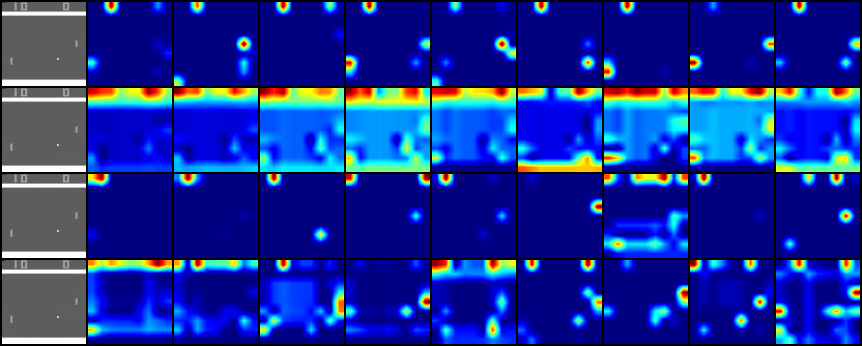

In [ ]:
images = []
for attn_type in ['NoAttn','Attn','RvuAttn','CrossAttn']:
  image = []
  for x in range(10,100,10):
  
    net = ActorCriticNet(env.observation_space.shape, env.action_space.n, attn_type, False)
    net = load(net, attn_type+'Epoch'+str(x)+'model.pt')
    # specify layer name to extract gradient from:
    gradcam = GradCAMpp(net, net.c2)
    # output will be the argmax of the model instead of log prob
    # because we need to find the gradient that contributes to the correct move
    output = torch.argmax(net(input), dim=1)
    # print(output)
    mask, logit = gradcam(input, class_idx=output)
    # print(input[0][0].size())
    heatmap, cam_result = visualize_cam(mask, input[0][0])
    image.extend([heatmap])
  image.insert(0,cam_result)
  images.extend(image)

grid_image = make_grid(images, nrow=10)
transforms.ToPILImage()(grid_image)